# Examining and Combining Cleaned Data
Check the cleaned data done on 08/02 and combine them into a large dataset. 

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
from sklearn.cluster import KMeans

In [146]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve

Get all the filenames in this current folder.

In [118]:
files = os.listdir('/home/wangmk/UM/Research/SURE/cleaned_data')

In [17]:
for file in files:
    full_name = '/home/wangmk/UM/Research/SURE/cleaned_data/'+file
    result = pd.read_csv(full_name)
    positive = np.sum(result['performance'])
    print(file,': ',positive)

cleaned_59.csv :  83
cleaned_50.csv :  68
cleaned_45.csv :  56
cleaned_4.csv :  67
cleaned_27.csv :  67
cleaned_71.csv :  80
cleaned_15.csv :  95
cleaned_31.csv :  75
cleaned_17.csv :  67
cleaned_36.csv :  84
cleaned_74.csv :  69
cleaned_38.csv :  75
cleaned_41.csv :  77
cleaned_79.csv :  79
cleaned_66.csv :  57
cleaned_52.csv :  71
cleaned_55.csv :  83
cleaned_22.csv :  68
cleaned_10.csv :  78
cleaned_24.csv :  81
cleaned_82.csv :  86
cleaned_43.csv :  50
cleaned_48.csv :  57
cleaned_76.csv :  65
cleaned_9.csv :  48
cleaned_88.csv :  63
cleaned_0.csv :  69
cleaned_20.csv :  38
cleaned_34.csv :  60
cleaned_72.csv :  76
cleaned_57.csv :  70
cleaned_62.csv :  64
cleaned_77.csv :  62
cleaned_2.csv :  52
cleaned_69.csv :  79
cleaned_29.csv :  75
cleaned_13.csv :  85
cleaned_7.csv :  68
cleaned_86.csv :  98


## Examine Data
The rest of the code snippets are used to get rid of some extreme values in some people's feedback.

In [22]:
kmeans = KMeans(n_clusters=2)

In [90]:
output = pd.read_csv('/home/wangmk/UM/Research/SURE/cleaned_data/cleaned_52.csv')

In [91]:
output = output.drop(output['RMS'].idxmax())
output = output.drop(output['RMS'].idxmax())

In [92]:
kmeans.fit(output['RMS'].values.reshape(-1,1))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [93]:
output['performance'] = kmeans.predict(output['RMS'].values.reshape(-1,1))

In [94]:
bad = output[output['performance']==0]
good = output[output['performance']==1]

In [95]:
print('Total median is ',np.median(output['RMS']))
print('Total mean is ',np.mean(output['RMS']))

Total median is  38.322392518872746
Total mean is  40.74455787705692


In [96]:
print(len(good))
print('The mean is',np.mean(good['RMS']))
print('The median is',np.median(good['RMS']))
print('The minimum is',np.min(good['RMS']))
print('The maximum is',np.max(good['RMS']))

33
The mean is 57.038308619212486
The median is 55.3357313679453
The minimum is 45.41223117965961
The maximum is 80.19951936110421


In [97]:
print(len(bad))
print('The mean is',np.mean(bad['RMS']))
print('The median is',np.median(bad['RMS']))
print('The minimum is',np.min(bad['RMS']))
print('The maximum is',np.max(bad['RMS']))

65
The mean is 32.47234596180869
The median is 32.022685313459704
The minimum is 15.629813116477699
The maximum is 44.1664014161839


In [71]:
output['performance'] = 1 - output['performance']

In [72]:
output['performance'] = output['performance'].astype('bool')

In [73]:
output.to_csv("/home/wangmk/UM/Research/SURE/cleaned_data/cleaned_59.csv")

## Combine Datasets and try Logistic Regression

Now I combine the datasets together. I have a full set and a reduced set. The reduced set doesn't contain the people that I feel are doing consistently well throughout the whole process.

First uniform all the columns of the datasets.

In [119]:
for file in files:
    df = pd.read_csv('/home/wangmk/UM/Research/SURE/cleaned_data/'+file)
    df.columns = ['Trial','True_state','Alert','Identification','First_toggle_time','RMS','Attention','Click','performance']
    df.to_csv('/home/wangmk/UM/Research/SURE/cleaned_data/'+file, index=False)

In [243]:
fullstack = pd.DataFrame(columns=['Trial','True_state','Alert','Identification','First_toggle_time','RMS','Attention','Click','performance'])

In [244]:
fullstack.head()

,Trial,True_state,Alert,Identification,First_toggle_time,RMS,Attention,Click,performance


In [245]:
for file in files:
    full_dir = "/home/wangmk/UM/Research/SURE/cleaned_data/" + file
    df = pd.read_csv(full_dir)
    fullstack = fullstack.append(df,ignore_index=True)

We need to convert every column to the correct datatype we need. The function below is used to transform the `Alert` column from object to boolean.

In [ ]:
def mapping(alert):
    if alert=='DANGER':
        return True
    else:
        return False

In [247]:
fullstack[['Trial','Click']] = fullstack[['Trial','Click']].astype(int)

In [ ]:
fullstack[['True_state','Identification','performance']] = fullstack[['True_state','Identification','performance']].astype(bool)

In [ ]:
fullstack['Alert'] = fullstack['Alert'].apply(mapping)

In [ ]:
fullstack['First_toggle_time'] = fullstack['First_toggle_time'].astype(float)

In [ ]:
fullstack['Agree'] = ~(fullstack['True_state'] ^ fullstack['Alert'])

In [256]:
fullstack.head(20)

,Trial,True_state,Alert,Identification,First_toggle_time,RMS,Attention,Click,performance,Agree
0,0,False,False,False,1611.0,67.992687,0.819095,2,False,True
1,1,False,False,False,778.0,28.956303,0.844221,2,True,True
2,3,False,False,False,388.0,48.778770,0.800000,2,False,True
3,4,False,False,False,946.0,46.872848,0.805970,2,False,True
4,5,False,False,True,-1.0,54.695426,1.000000,0,False,True
5,6,False,False,False,361.0,66.688618,0.835000,2,False,True
6,7,False,False,False,631.0,33.775268,0.810000,2,True,True
7,8,True,True,True,985.0,39.838031,0.905473,2,True,True
8,9,False,False,False,2834.0,23.535136,0.860000,2,True,True
9,10,False,True,False,2368.0,84.416877,0.691919,2,False,False


In [257]:
fullstack.to_csv('/home/wangmk/UM/Research/SURE/cleaned_data/full_cleaned_data.csv',index=False)

Try logistic regression on the big dataset.

In [258]:
X = fullstack.drop(['RMS','First_toggle_time','performance'],axis=1)
y = fullstack['performance']

In [259]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state=42,stratify=y)

In [260]:
logreg = LogisticRegression()

In [261]:
logreg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [262]:
y_pred = logreg.predict(X_test)

In [263]:
print(confusion_matrix(y_test, y_pred))

[[ 83 307]
 [ 64 745]]


In [265]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

      False       0.56      0.21      0.31       390
       True       0.71      0.92      0.80       809

avg / total       0.66      0.69      0.64      1199



In [266]:
np.sum(fullstack['performance'])/3994

0.6745117676514772

Outcome is no better than merely guessing:(.

In [267]:
y_pred_prob = logreg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

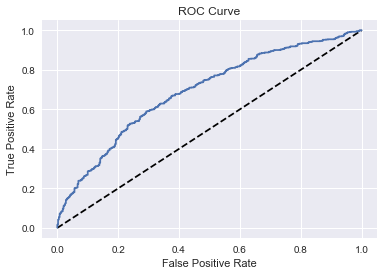

In [268]:
sns.set()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [269]:
print("AUC: {}".format(roc_auc_score(y_test,y_pred_prob)))

AUC: 0.689794301289975


The AUC is also very low :(.

I now prepare another reduced set. Compared with the full set, this reduced set doesn't contain the people that perform consistently well(always very low).

In [170]:
# subset people id
subset = [0,4,7,10,13,15,22,27,29,31,34,36,38,41,45,48,50,52,55,59,62,
                64,66,69,71,72,74,79,82,86,88]

In [187]:
substack = pd.DataFrame(columns=['Trial','True_state','Alert','Identification','First_toggle_time','RMS','Attention','Click','performance'])

In [188]:
for person in subset:
    full_dir = "/home/wangmk/UM/Research/SURE/cleaned_data/cleaned_" + str(person) + '.csv'
    df = pd.read_csv(full_dir)
    substack = substack.append(df,ignore_index=True)

In [191]:
substack[['True_state','Identification','performance']] = substack[['True_state','Identification','performance']].astype(bool)

In [194]:
substack['Alert'] = substack['Alert'].apply(mapping)

In [197]:
substack['Agree'] = ~(substack['Alert'] ^ substack['True_state'])

In [199]:
substack['First_toggle_time'] = substack['First_toggle_time'].astype(float)

In [202]:
substack[['Trial','Click']] = substack[['Trial','Click']].astype(int)

In [272]:
substack.head(20)

,Trial,True_state,Alert,Identification,First_toggle_time,RMS,Attention,Click,performance,Agree
0,0,True,True,True,4179.0,65.244487,0.914573,2,False,True
1,1,False,False,False,3653.0,67.293907,0.895000,2,False,True
2,2,False,True,False,2186.0,100.119892,0.854271,2,False,False
3,3,False,False,False,3412.0,33.403009,0.889447,2,True,True
4,4,False,False,False,4514.0,70.063858,0.929648,2,False,True
5,5,True,False,True,8141.0,27.348088,0.920000,2,True,False
6,6,False,True,False,994.0,28.984222,0.909548,2,True,False
7,7,False,False,False,6131.0,38.653724,0.904523,2,True,True
8,8,True,False,True,928.0,38.260605,0.920398,2,True,False
9,9,True,False,True,1958.0,48.263854,0.934343,2,True,False


Try logistic regression on it as well.

In [232]:
X = substack.drop(['RMS','First_toggle_time','performance','Trial'],axis=1)
y = substack['performance']

In [233]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state=42,stratify=y)

In [234]:
logreg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [235]:
y_pred = logreg.predict(X_test)

In [236]:
print(confusion_matrix(y_test, y_pred))

[[  8 272]
 [  3 646]]


In [237]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

      False       0.73      0.03      0.05       280
       True       0.70      1.00      0.82       649

avg / total       0.71      0.70      0.59       929



In [238]:
sum(substack['performance'])/3094

0.6984486102133161

No improvement :(.

In [240]:
y_pred_prob = logreg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

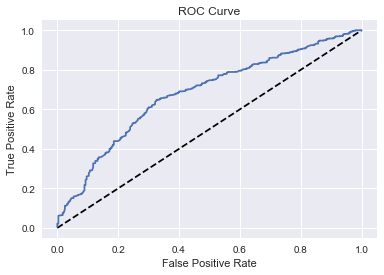

In [241]:
sns.set()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [242]:
print("AUC: {}".format(roc_auc_score(y_test,y_pred_prob)))

AUC: 0.6786842394893242


In [273]:
substack.to_csv('/home/wangmk/UM/Research/SURE/cleaned_data/sub_cleaned_data.csv',index=False)